## TODO refactor & document properly

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import train
from unet import UNet, UNetCD, LinearCD

In [8]:
%pdb

Automatic pdb calling has been turned ON


The cell below is used to _load_ a checkpoint.

To instantiate a new one, use the one following it.

In [86]:
    tr = train.load_trainer(
        batch_size=256,
        device='cuda',
        sample_type='scaled', optimizer=torch.optim.AdamW, loss_fn=torch.nn.functional.mse_loss,
        print_every=1,
        save_every=5,
        network_type=UNet,
        num_workers=6,
        end_character='\n')
    extend_network = tr.problem.network

In [10]:
try:
    extend_network
except NameError:
    extend_network = False

tr = train.create_trainer(num_initializations=50,
                              network_type=UNet,
                              sample_type='scaled',
                              batch_size=256, # SimpleNet 64x64 - whole dataset fits in memory
                              device='cpu',
                              optimizer=torch.optim.SGD,
                              #loss_fn=train.relative_error_loss,
                              loss_fn=torch.nn.functional.l1_loss,
                              optimizer_params={'momentum': 0.8, 'lr': 1e-3},
                              print_every=1,
                              save_every=50,
                              num_workers=6,
                              end_character='\n',
                         extend_network=extend_network)

an = train.Analyzer(tr, device='cuda')

In [109]:
tr.epochs(3)


plt.gcf().set_size_inches(14, 8)
plt.rcParams.update({'font.size': 22})

plt.savefig('./checkpoints/loss-plot.png')

an = train.Analyzer(tr, device='cuda')

Epoch: 18, train loss: 0.08315044641494751, val loss:: 0.11121910810470581 , elapsed time: 0:09:23.698105
Epoch: 19, train loss: 0.08319298923015594, val loss:: 0.11203853040933609 , elapsed time: 0:09:39.032908
Epoch: 20, train loss: 0.08326707780361176, val loss:: 0.11027085781097412 , elapsed time: 0:09:54.158298


<Figure size 1008x576 with 0 Axes>

In [21]:
tr.problem.network

SimpleNet(
  (conv1): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
)

In [107]:
    for param_group in tr.problem.optimizer.param_groups:
        param_group['lr'] = 1e-5  # last


In [70]:
an = train.Analyzer(tr, device='cuda')

In [65]:
losses = an.all_losses()

In [66]:
np.mean(losses)

7.054125714111546

##  C_D error

In [104]:
abs_relative_diffs = []
relative_diffs = []
cd_exp = []
cd_pred = []

split = 'test'

for i in range(an.num_samples(split)):
    exp = float(an.ith_exp(i, split).squeeze().cpu().numpy())
    pred = float(an.apply_network(i, split).squeeze().cpu().numpy())
    cd_exp.append(exp)
    cd_pred.append(pred)
    abs_relative_diffs.append(
        np.abs(exp - pred) / np.abs(exp)
    )
    relative_diffs.append((pred - exp) / exp)

In [105]:
np.mean(abs_relative_diffs)

0.16152843712121542

## Guo's error

In [72]:
errors = an.relative_error_guo(split='train')

IndexError: too many indices for array

In [16]:
np.min(errors), np.mean(errors), np.median(errors)

(0.17331874843531442, 0.5558316519649849, 0.4131698219731721)

##  Thuerey's error

In [17]:
print('thuerey')
print('  all: ', np.median(an.relative_error_thuerey(channel='all')))
print('  x: ', np.median(an.relative_error_thuerey(channel='x')))
print('  y: ', np.median(an.relative_error_thuerey(channel='y')))
print('  p: ', np.median(an.relative_error_thuerey(channel='p')))

thuerey
  all:  0.34470898
  x:  0.288144
  y:  0.32527763
  p:  0.50797963


In [38]:
np.median(an.relative_error_thuerey(channel='x'))

0.24419144

In [39]:
np.mean(an.relative_error_thuerey(channel='y'))

0.38835144

In [40]:
np.mean(an.relative_error_thuerey(channel='p'))

0.9783419

In [33]:
np.mean(an.relative_error_thuerey(channel='all', split='val'))

0.7070181

## Now my rel err

In [26]:
print('my relative error')
print('  all: ', np.median(an.relative_error(channel='all', split='train', stat='median')))

xyp = (np.median(an.relative_error(channel='x', split='train', stat='median')), 
 np.median(an.relative_error(channel='y', split='train', stat='median')),
 np.median(an.relative_error(channel='p', split='train', stat='median')))

print('  x y p: ', xyp)

my relative error
  all:  0.26893806
  x y p:  (0.22174275, 0.27390087, 0.421306)


In [9]:
np.median(an.relative_error(channel='all', split='test', stat='median'))

KeyError: 'test'

In [ ]:
np.median(an.relative_error(channel='all', split='val', stat='median'))

In [36]:
(np.median(an.relative_error(channel='x', split='train', stat='median')), 
 np.median(an.relative_error(channel='y', split='train', stat='median')),
 np.median(an.relative_error(channel='p', split='train', stat='median')))

(0.22178033, 0.27344045, 0.41759893)

In [ ]:
(np.median(an.relative_error(channel='x', split='val', stat='median')), 
 np.median(an.relative_error(channel='y', split='val', stat='median')),
 np.median(an.relative_error(channel='p', split='val', stat='median')))

## Generating images

In [27]:
all_mean_rel_errors = an.relative_error(channel='all', i=None, stat='mean')
best = np.argmin(all_mean_rel_errors)
worst = np.argmax(all_mean_rel_errors)

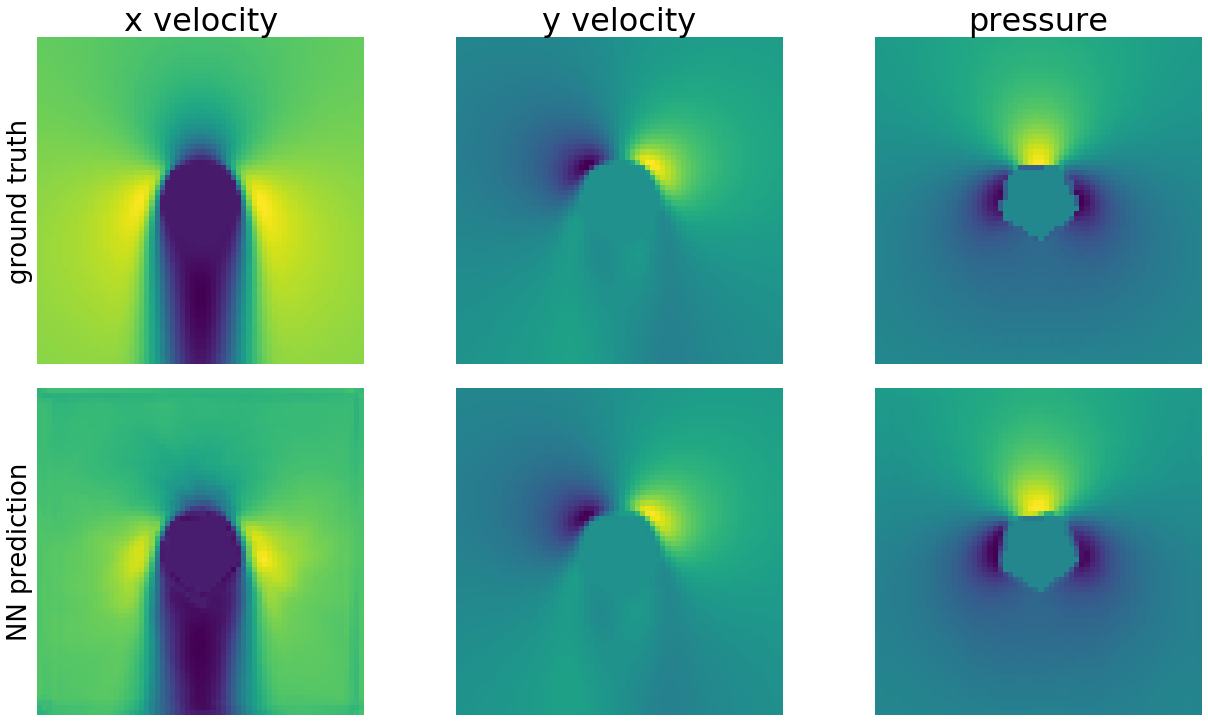

In [28]:
sample = best


plt.rc('axes', titlesize=32)     # fontsize of the axes title
plt.rc('axes', labelsize=26)     # fontsize of the axes title

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(18.5, 10.5)
#plt.rcParams.update({'font.size': 22})


channel = 'x'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 0])


axs[0, 0].set(ylabel='ground truth')
# make xaxis invisibel
axs[0, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[0,0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[0, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[0,0].patch.set_visible(False)

axs[0, 0].set_title('x velocity')

an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 0])

axs[1, 0].set(ylabel='NN prediction')
# make xaxis invisibel
axs[1, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[1, 0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[1, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[1, 0].patch.set_visible(False)




channel = 'y'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 1])
axs[0, 1].set_title('y velocity')
axs[0, 1].axis('off')
an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 1])
axs[1, 1].axis('off')

channel = 'p'
an.plot_ith_press_exp(sample, axis=axs[0, 2])
axs[0, 2].axis('off')
axs[0, 2].set_title('pressure')
an.plot_ith_press_pred(sample, axis=axs[1, 2])
axs[1, 2].axis('off')

plt.tight_layout()

fig.savefig('./checkpoints/best.png')

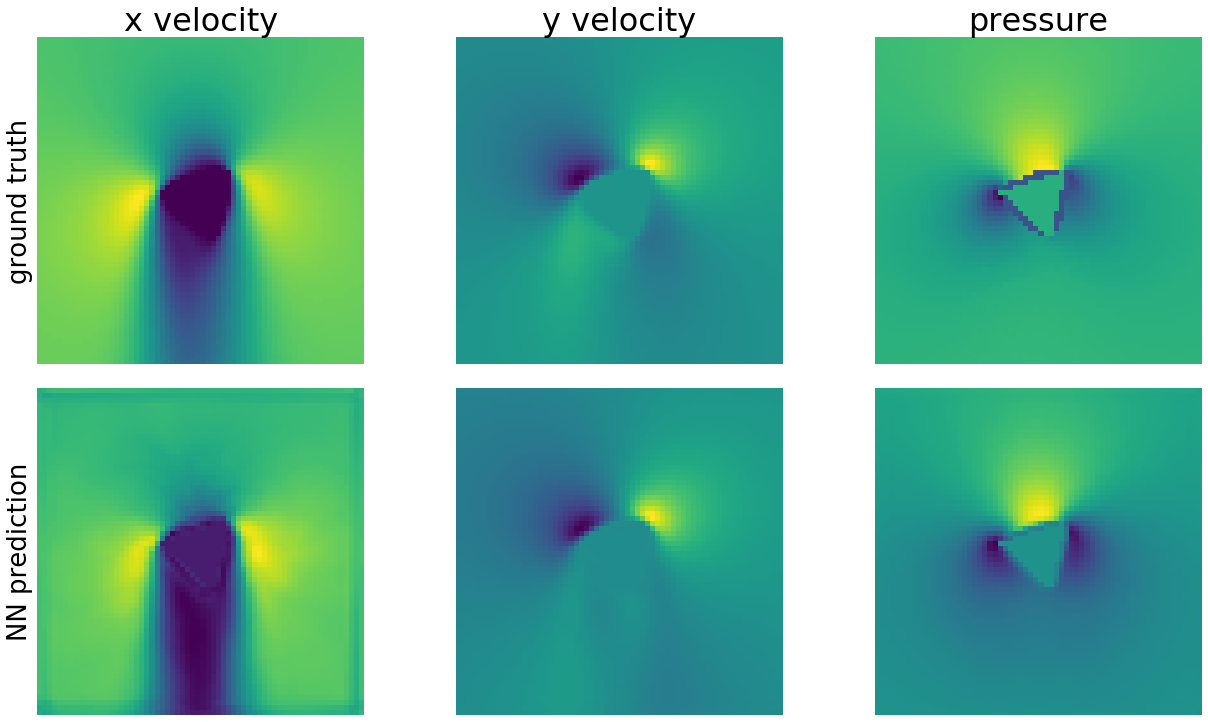

In [29]:
sample = worst

fig, axs = plt.subplots(2, 3)
#fig.suptitle('Best network')
fig.set_size_inches(18.5, 10.5)


    
channel = 'x'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 0])


axs[0, 0].set(ylabel='ground truth')
# make xaxis invisibel
axs[0, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[0,0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[0, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[0,0].patch.set_visible(False)

axs[0, 0].set_title('x velocity')

an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 0])

axs[1, 0].set(ylabel='NN prediction')
# make xaxis invisibel
axs[1, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[1, 0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[1, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[1, 0].patch.set_visible(False)




channel = 'y'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 1])
axs[0, 1].set_title('y velocity')
axs[0, 1].axis('off')
an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 1])
axs[1, 1].axis('off')

channel = 'p'
an.plot_ith_press_exp(sample, axis=axs[0, 2])
axs[0, 2].axis('off')
axs[0, 2].set_title('pressure')
an.plot_ith_press_pred(sample, axis=axs[1, 2])
axs[1, 2].axis('off')

plt.tight_layout()
fig.savefig('./checkpoints/worst.png')

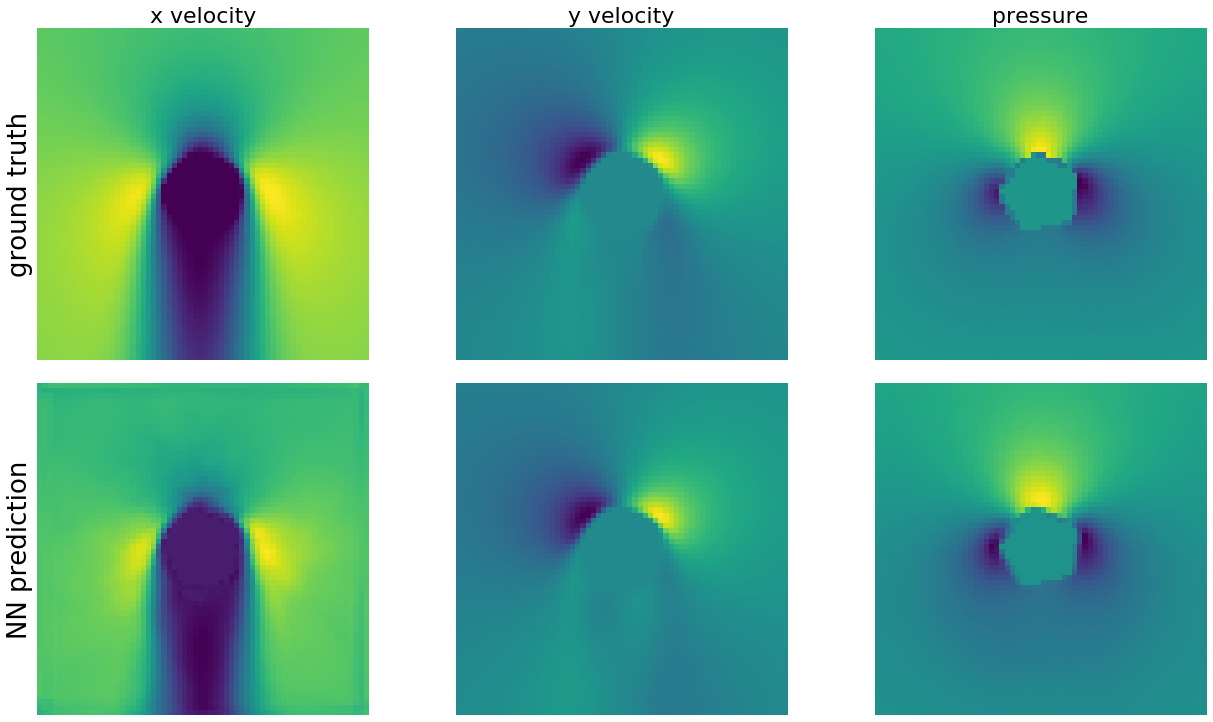

In [30]:
sample = np.random.randint(0, high=an.num_samples('train'))

fig, axs = plt.subplots(2, 3)
#fig.suptitle('Best network')
fig.set_size_inches(18.5, 10.5)
# plt.rcParams.update({'font.size': 22})
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=22)



    
channel = 'x'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 0])


axs[0, 0].set(ylabel='ground truth')
# make xaxis invisibel
axs[0, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[0,0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[0, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[0,0].patch.set_visible(False)

axs[0, 0].set_title('x velocity')

an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 0])

axs[1, 0].set(ylabel='NN prediction')
# make xaxis invisibel
axs[1, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[1, 0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[1, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[1, 0].patch.set_visible(False)




channel = 'y'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 1])
axs[0, 1].set_title('y velocity')
axs[0, 1].axis('off')
an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 1])
axs[1, 1].axis('off')

channel = 'p'
an.plot_ith_press_exp(sample, axis=axs[0, 2])
axs[0, 2].axis('off')
axs[0, 2].set_title('pressure')
an.plot_ith_press_pred(sample, axis=axs[1, 2])
axs[1, 2].axis('off')

plt.tight_layout()
fig.savefig('./checkpoints/random.png')

## C_D plots

split = 'train'

exps = []
preds = []

for i in range(10): # range(an.num_samples(split)):
    exp = float(an.ith_exp(return_type='numpy', split=split, i=i))
    pred = float(an.apply_network(return_type='numpy', split=split, i=i))
    exps.append(exp)
    preds.append(pred)
    
    
relative_diffs = [ (p - e)/e for (e, p) in zip(exps, preds)]

Text(0.5, 41.0, 'relative error')

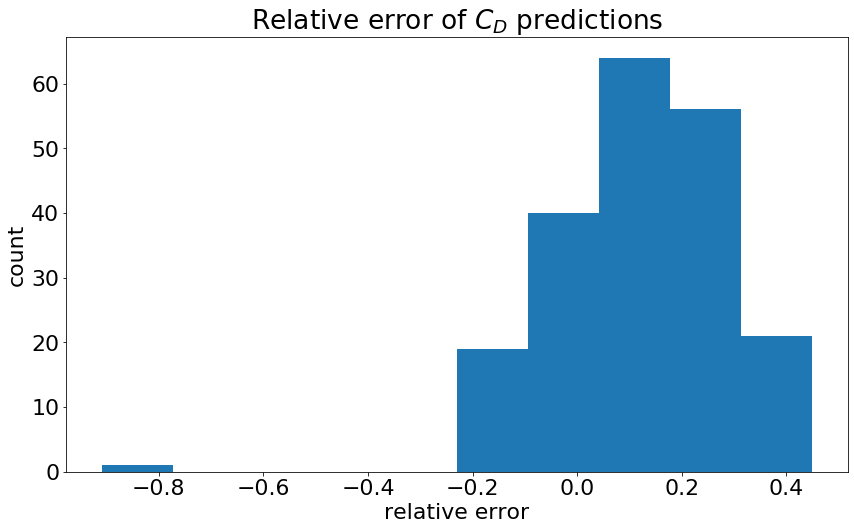

In [106]:
plt.hist(relative_diffs)
plt.gcf().set_size_inches(14, 8)
plt.rcParams.update({'font.size': 22})
plt.title('Relative error of $C_D$ predictions')
plt.savefig('./checkpoints/cd.png')
plt.ylabel('count')
plt.xlabel('relative error')

In [64]:
import pandas as pd

pd.Series(cd_exp).describe()

count    7008.000000
mean        1.403491
std         0.131708
min         1.017002
25%         1.348473
50%         1.440342
75%         1.440342
max         1.907773
dtype: float64

In [63]:
pd.Series(cd_pred).describe()

count    7008.000000
mean       11.459937
std         0.146797
min        11.257374
25%        11.329782
50%        11.417348
75%        11.570110
max        11.863671
dtype: float64

In [45]:
pd.Series((np.abs(e - p)/np.abs(e) for (e, p) in zip(cd_exp, cd_pred))).describe()

count    201.000000
mean       0.162962
std        0.121045
min        0.001294
25%        0.067458
50%        0.140262
75%        0.246615
max        0.909977
dtype: float64

0.07142857142857144